In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np
data = pd.read_csv('test3.csv', encoding='gbk')

In [3]:
# 将"order_dt"列转换为日期类型
data['order_dt'] = pd.to_datetime(data['order_dt'])

# 创建条件来选择在指定日期范围内的数据
start_date = pd.to_datetime("2022-09-01")
end_date = pd.to_datetime("2022-09-30")
mask_train = (data['order_dt'] >= start_date) & (data['order_dt'] <= end_date)
mask_test = (~(data['order_dt'] >= start_date) & (data['order_dt'] <= end_date))

test1 = data[mask_test]

In [4]:
dataX=[]#属性
dataY=[]#标签
k=0
tempX=[]#储存某个历史167天数据
tempY=[]#储存某个未来1天数据,即第168天
for index, rows in data.iterrows():
    if k<168:
        k+=1
        tempX.append([rows['pay_num'],rows['payment_orders'],rows['refund_orders'],rows['cancel_orders'],rows['income'],rows['refund_income'],rows['actual_orders'],rows['续费率'],rows['实际收入'],rows['保留率'],rows['ltv']])
        
        continue
    if k<169:
        k = 0
        # print(rows['week'])
        tempY.append([rows['pay_num'],rows['payment_orders'],rows['refund_orders'],rows['cancel_orders'],rows['income'],rows['refund_income'],rows['actual_orders'],rows['续费率'],rows['实际收入'],rows['保留率'],rows['ltv']])
        
        dataX.append(tempX)
        dataY.append(tempY)
        tempX=[]#储存某个历史167天数据
        tempY=[]#储存某个未来1天数据,即第168天
        continue


In [5]:
import torch
import torch.utils.data as Data
 
dataX=torch.tensor(dataX)#列表转Tensor
dataY=torch.tensor(dataY)#列表转Tensor
 
dataset=Data.TensorDataset(dataX,dataY)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])#以8:2比例划分训练集和测试集
 
train_loader = Data.DataLoader(
            dataset=train_dataset,
            batch_size=64,
            shuffle=True
        )
test_loader = Data.DataLoader(
            dataset=test_dataset,
            batch_size=64,
            shuffle=False
        )

In [6]:
from torch.nn import LSTM,Module,Linear
class MyModel(Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.lstm=LSTM(input_size=11,hidden_size=11,num_layers=2,batch_first=True)
        self.linear=Linear(168*11,1*11)#将结果映射到7天的数据
    def forward(self,x):
        return self.linear(self.lstm(x)[0].reshape(-1,168*11))

In [7]:
import torch.nn.functional as F

loaded_model = torch.load('0to167predict168.pkl')

model=MyModel()
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossList=[]#记录训练loss
lossListTest=[]#记录测试loss
epochs = 500
for epoch in range(epochs):
    loss_nowEpoch=[]
    model.train()
    for step, (batch_x, batch_y) in enumerate(train_loader):
        out=model(batch_x)#模型输入
        Loss = F.mse_loss(out,batch_y.view(-1,11))#loss计算，将batch_y从(64,1,11)变形为(64,11)
        optimizer.zero_grad()#当前batch的梯度不会再用到，所以清除梯度
        Loss.backward()#反向传播计算梯度
        optimizer.step()#更新参数
        loss_nowEpoch.append(Loss.item())
        break
    lossList.append(sum(loss_nowEpoch)/len(loss_nowEpoch))
 
    loss_nowEpochTest = []
    model.eval()
    for step, (batch_x, batch_y) in enumerate(test_loader):
        out = model(batch_x)
        Loss = F.mse_loss(out, batch_y.view(-1, 11))  # 将batch_y从(64,1,11)变形为(64,11)
        loss_nowEpochTest.append(Loss.item())
        break
    lossListTest.append(sum(loss_nowEpochTest)/len(loss_nowEpochTest))
 
    print(">>> EPOCH{} averTrainLoss:{:.3f} averTestLoss:{:.3f}".format(epoch+1, lossList[-1],lossListTest[-1]))

torch.save(model.state_dict(), '0to167predict168.pkl')

>>> EPOCH1 averTrainLoss:0.027 averTestLoss:2.371
>>> EPOCH2 averTrainLoss:2.408 averTestLoss:0.149
>>> EPOCH3 averTrainLoss:0.148 averTestLoss:0.756
>>> EPOCH4 averTrainLoss:0.737 averTestLoss:1.384
>>> EPOCH5 averTrainLoss:1.297 averTestLoss:0.903
>>> EPOCH6 averTrainLoss:0.925 averTestLoss:0.257
>>> EPOCH7 averTrainLoss:0.255 averTestLoss:0.160
>>> EPOCH8 averTrainLoss:0.181 averTestLoss:0.435
>>> EPOCH9 averTrainLoss:0.467 averTestLoss:0.597
>>> EPOCH10 averTrainLoss:0.619 averTestLoss:0.475
>>> EPOCH11 averTrainLoss:0.499 averTestLoss:0.254
>>> EPOCH12 averTrainLoss:0.277 averTestLoss:0.149
>>> EPOCH13 averTrainLoss:0.155 averTestLoss:0.186
>>> EPOCH14 averTrainLoss:0.178 averTestLoss:0.267
>>> EPOCH15 averTrainLoss:0.244 averTestLoss:0.300
>>> EPOCH16 averTrainLoss:0.291 averTestLoss:0.256
>>> EPOCH17 averTrainLoss:0.228 averTestLoss:0.170
>>> EPOCH18 averTrainLoss:0.163 averTestLoss:0.101
>>> EPOCH19 averTrainLoss:0.117 averTestLoss:0.080
>>> EPOCH20 averTrainLoss:0.090 averTest

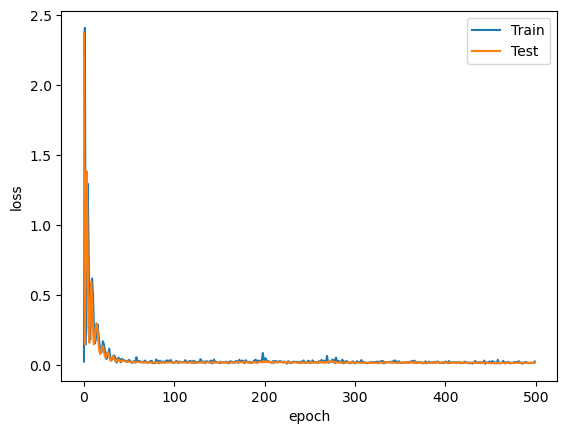

In [9]:
import matplotlib.pyplot as plt
plt.plot(list(range(epochs)),lossList,label='Train')
plt.plot(list(range(epochs)),lossListTest,label='Test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
dataX1=[]#属性
dataY1=[]#标签
k=0
tempX=[]#储存某个历史167天数据
tempY=[]#储存某个未来1天数据,即第168天
for index, rows in test1.iterrows():
    if k<168:
        k+=1
        tempX.append([rows['pay_num'],rows['payment_orders'],rows['refund_orders'],rows['cancel_orders'],rows['income'],rows['refund_income'],rows['actual_orders'],rows['续费率'],rows['实际收入'],rows['保留率'],rows['ltv']])
        
        continue
    if k<169:
        k = 0
        # print(rows['week'])
        tempY.append([rows['pay_num'],rows['payment_orders'],rows['refund_orders'],rows['cancel_orders'],rows['income'],rows['refund_income'],rows['actual_orders'],rows['续费率'],rows['实际收入'],rows['保留率'],rows['ltv']])
        
        dataX1.append(tempX)
        dataY1.append(tempY)
        tempX=[]#储存某个历史167天数据
        tempY=[]#储存某个未来1天数据,即第168天
        continue

In [11]:
X=torch.tensor(dataX1)
Y=model(X.view(len(dataX1),168,11).float()).reshape(len(dataX1),11)

In [12]:
a1 = []
a2 = []
for i in Y.tolist():
    a1.append(i[-1])

for i in dataY1:
    a2.append(i[0][-1])

a2 = np.array(a2)
a1 = np.array(a1)

In [13]:
# 计算相对误差
relative_errors = np.abs((a2 - a1) / a2)

# 统计relative_errors中大于0.1的数量
count_greater_than_0_1 = (relative_errors > 0.1).sum()

# 统计relative_errors中小于等于0.1的数量
count_less_than_or_equal_to_0_1 = (relative_errors <= 0.1).sum()

print(f"大于0.1的数量：{count_greater_than_0_1}")
print(f"小于等于0.1的数量：{count_less_than_or_equal_to_0_1}")
print('合格率：', count_less_than_or_equal_to_0_1/(count_less_than_or_equal_to_0_1+count_greater_than_0_1))


大于0.1的数量：5
小于等于0.1的数量：624
合格率： 0.9920508744038156
